# Sentiment Analysis — IMDb Movie Reviews

Michael Richman <br/>
mike.d.richman@gmail.com <br/>
http://github.com/zgana

In this notebook, we classify IMDb movie reviews as "positive" or "negative" using a classic dataset of 100k reviews.

**Contents:**

* [Tools](#Tools)
* [Dataset introduction](#Dataset-introduction)
* [Data load](#Data-load)
* [Initial exploration](#Initial-exploration)
* [Bag-of-ngrams vectorization](#Bag-of-ngrams-vectorization)
* [Initial classifiers — validation](#Initial-classifiers-—-validation)
* [Choosing a final architecture](#Choosing-a-final-architecture)
* [Final model](#Final-model)
* [Follow-up on misclassifications](#Follow-up-on-misclassifications)
* [Conclusions](#Conclusions)

## Tools

In [1]:
# standard library
import itertools
import os
import re
import string
import sys
import textwrap

# scientific stack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import sparse

# markup parsing
from bs4 import BeautifulSoup

# basic ML tools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model, ensemble, metrics

# XGBoost for gradient boosting
import xgboost as xgb

# Keras interface to Tensorflow
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout

# Natural Language Processing Toolkit
import nltk

# Personal histogram / kernel density estimate tool
# https://histlite.readthedocs.io/
import histlite as hl

%matplotlib inline

In [2]:
plt.rc('figure', dpi=100)

In [3]:
def prush(*a, **kw):
    """Print, and immediately flush for prompt progress updates."""
    print(*a, **kw)
    sys.stdout.flush()

In [4]:
def pfill(s, width=90):
    """Print string with text wrapping."""
    print(textwrap.fill(s, width=width))

## Dataset introduction

The dataset was obtained from website of the researchers who assembled it:

https://ai.stanford.edu/~amaas/data/sentiment/

Their paper on this work is also available online:

https://www.aclweb.org/anthology/P11-1015

The authors request that they be cited in work using this dataset.  However, since it was originally mined from IMDb, it seems likely that their licensing conditions apply.  These are laid out at https://www.imdb.com/conditions, and include a provision that commercial use requires licensing through their licensing department as described here: https://www.imdb.com/licensing/.

## Data load

In preparation for this work, the dataset was downloaded onto a machine with ample resources (especially RAM) and unzipped.

In [5]:
DATA_PATH = '/data/condor_builds/users/richman/data'
IMDB_PATH = os.path.join(DATA_PATH, 'aclImdb')
TRAIN_PATH = os.path.join(IMDB_PATH, 'train')
TEST_PATH = os.path.join(IMDB_PATH, 'test')
UNSUP_PATH = os.path.join(TRAIN_PATH, 'unsup')

In [6]:
def clean_text(text):
    """Strip HTML tags with BeautifulSoup."""
    return BeautifulSoup(text, 'lxml').get_text()

In [7]:
def load_sup_dataset(path, max=np.inf):
    """Load pos/neg divided reviews from train or test dir."""
    texts = []
    ratings = []
    posnegs = []
    
    rating_pattern = re.compile(r'.*_(\d+).txt')
    for (i_sent, sent) in enumerate(['neg', 'pos']):
        prush(f'Reading {sent} ...')
        sent_path = os.path.join(path, sent)
        for (i, filename) in enumerate(sorted(os.listdir(sent_path))):
            if not i % 2000:
                prush(f'\r{i} ...', end='')
            rating = int(rating_pattern.match(filename)[1])
            abs_filename = os.path.join(sent_path, filename)
            with open(abs_filename) as f:
                text = clean_text(f.read())
            texts.append(text)
            ratings.append(rating)
            posnegs.append(i_sent)
            if i >= max:
                break
        prush()
    return pd.DataFrame(dict(rating=ratings, pos=posnegs, text=texts))

In [8]:
def load_unsup_dataset(path, max=np.inf):
    """Load reviews for unsupervised learning."""
    texts = []
    for (i, filename) in enumerate(sorted(os.listdir(path))):
        if not i % 10000:
            prush(f'\r{i} ...', end='')
        abs_filename = os.path.join(path, filename)
        with open(abs_filename) as f:
            text = clean_text(f.read())
        texts.append(text)
        if i >= max:
            break
    prush()
    return pd.DataFrame(dict(text=np.array(texts)))

Until we have our strategy finalized, we'll restrict our attention to the "train" (labeled) and "unsup" (unlabeled) datasets:

In [9]:
%time train = load_sup_dataset(TRAIN_PATH)

Reading neg ...
12000 ...
Reading pos ...
12000 ...
CPU times: user 13 s, sys: 1.68 s, total: 14.7 s
Wall time: 22.8 s


In [10]:
%time unsup = load_unsup_dataset(UNSUP_PATH)

40000 ...
CPU times: user 26.8 s, sys: 4.39 s, total: 31.2 s
Wall time: 47.4 s


In [11]:
train.head()

,rating,pos,text
0,3,0,Story of a man who has unnatural feelings for ...
1,4,0,Airport '77 starts as a brand new luxury 747 p...
2,4,0,This film lacked something I couldn't put my f...
3,1,0,"Sorry everyone,,, I know this is supposed to b..."
4,1,0,When I was little my parents took me along to ...


In [12]:
unsup.tail()

,text
49995,"Delightfully awful! Made by David Giancola, a ..."
49996,"Watching Time Chasers, it obvious that it was ..."
49997,At the beginning we can see members of Troma t...
49998,"The movie was incredible, ever since I saw it ..."
49999,"TCM came through by acquiring this wonderful, ..."


In [13]:
train_unsup = pd.DataFrame(dict(text=np.concatenate((train.text.values, unsup.text.values))))

In [14]:
train_unsup.tail()

,text
74995,"Delightfully awful! Made by David Giancola, a ..."
74996,"Watching Time Chasers, it obvious that it was ..."
74997,At the beginning we can see members of Troma t...
74998,"The movie was incredible, ever since I saw it ..."
74999,"TCM came through by acquiring this wonderful, ..."


The set of ratings included is as follows:

In [15]:
np.unique(train.rating.values)

array([ 1,  2,  3,  4,  7,  8,  9, 10])

5 and 6 are excluded as "neutral".  Here is one of the unlabeled reviews:

In [16]:
pfill(unsup.text.values[-1])

TCM came through by acquiring this wonderful, silent, comedy/drama for television. Until
recently it had been locked away in an achieve somewhere. It premiered on TV for the 1st
time since its theatrical release in 1927. Two Americans fighting in World War I (William
Boyd and Louis Wolheim) are hiding in a defensive position with German soldiers advancing.
They however are fighting with each other and working the nerve of one-an-other. They of
course are caught, but after an inventive escape they are taken on a whirlwind adventure
in Arabia, with all the humor you might find in an Abbott and Costello movie. Very funny
and sometimes even touching. A great silent picture and winner of an Academy Award for
"Best Comedy Direction". Directed by Lewis Milestone.


## Initial exploration

A simple first question is: how many words are in the train+unsup corpus, and how are their word counts distributed?  So we start with a `CountVectorizer`:

In [17]:
counter = CountVectorizer(
    decode_error='replace',
    strip_accents='unicode',
    dtype='int32',
)

In [18]:
%time counts_train_unsup = counter.fit_transform(train_unsup.text.values)
counts_train_unsup

CPU times: user 11.5 s, sys: 90.1 ms, total: 11.6 s
Wall time: 11.6 s


<75000x126389 sparse matrix of type '<class 'numpy.int32'>'
	with 10315095 stored elements in Compressed Sparse Row format>

We access the entire word list and corresponding counts, and then sort by descending counts.

In [19]:
all_words = np.array(counter.get_feature_names())
all_words_counts = np.array(counts_train_unsup.sum(axis=0).tolist()[0])
order = np.argsort(all_words_counts)[::-1]
all_words, all_words_counts = all_words[order], all_words_counts[order]

The distribution of counts looks like so:

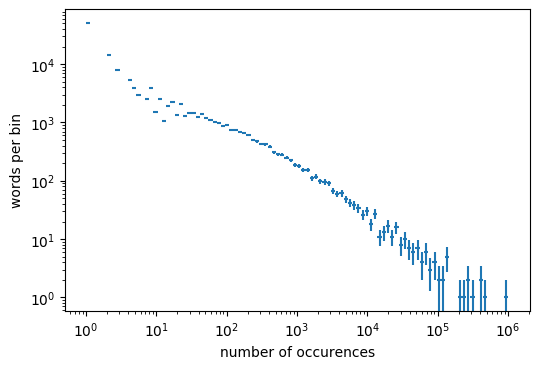

In [20]:
h = hl.hist(all_words_counts, bins=100, log=True)
hl.plot1d(h, crosses=True)
plt.loglog()
plt.xlabel('number of occurences')
plt.ylabel('words per bin');

The most common words are:

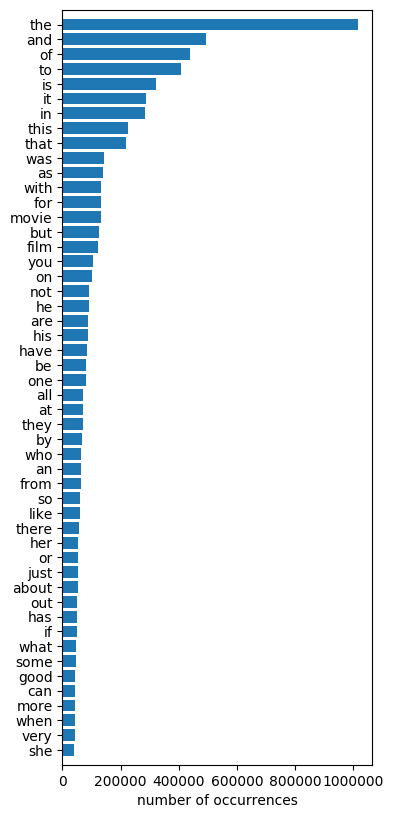

In [21]:
fig, ax = plt.subplots(figsize=(4,10))
n = 50
words, counts = all_words[:n][::-1], all_words_counts[:n][::-1]
ax.barh(words, counts)
ax.set_ylim(-1, n)
plt.yticks(words)
plt.xlabel('number of occurrences');

We'll use the total word counts to define a list of `stop_words`, though we'll manually whitelist some words that may be relevant for sentiment analysis.

In [22]:
stop_words = list(words)
whitelist_words = 'but not like just good'.split()
for word in whitelist_words:
    stop_words.remove(word)
pfill(' '.join(stop_words))

she very when more can some what if has out about or her there so from an who by they at
all one be have his are he on you film movie for with as was that this in it is to of and
the


We can also look at the distribution of review lengths, in terms of word count:

In [23]:
train_unsup['wordcount'] = review_wordcounts = np.array(counts_train_unsup.sum(axis=1).tolist()).ravel()

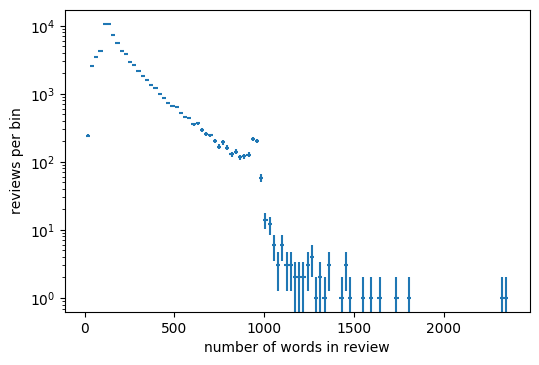

In [24]:
hl.plot1d(hl.hist(review_wordcounts, bins=100), crosses=True)
plt.semilogy()
plt.xlabel('number of words in review')
plt.ylabel('reviews per bin');

## Bag-of-ngrams vectorization

We'll focus on bag-of-ngrams methods, and explore a few options for vectorizing reviews.

In [25]:
n_ngrams = (1, 2, 3)

### n-grams with simple sklearn tokenization

First we try a simple word-based tokenization, allowing (separately) for 5k unigrams, bigrams, and trigrams.  While our models won't be able to learn relationships involving words not found in the labeled training data, they may still benefit from higher statistics in the TF-IDF weighting.

In [26]:
tfidf_defaults = dict(
    min_df=3,
    max_features=5_000,
    decode_error='replace',
    strip_accents='unicode',
    stop_words=stop_words)

In [27]:
default_vectorizers = {}
default_train_vectors = {}
for i in n_ngrams:
    prush(f'Fitting {i}-grams with train + unsup datasets...')
    kw = {}
    kw.update(tfidf_defaults)
    kw['ngram_range'] = (i, i)
    vectorizer = TfidfVectorizer(**kw)
    vectorizer.fit(train_unsup.text.values)
    prush(f'Transforming {i}-grams in train dataset...')
    train_vectors = vectorizer.transform(train.text.values)
    default_vectorizers[i] = vectorizer
    default_train_vectors[i] = train_vectors

Fitting 1-grams with train + unsup datasets...
Transforming 1-grams in train dataset...
Fitting 2-grams with train + unsup datasets...
Transforming 2-grams in train dataset...
Fitting 3-grams with train + unsup datasets...
Transforming 3-grams in train dataset...


In [28]:
all_default_ngrams = {}
all_default_ngrams_counts = {}
for i in n_ngrams:
    ngrams = np.array(default_vectorizers[i].get_feature_names())
    counts = np.array(default_train_vectors[i].sum(axis=0).tolist()[0])
    order = np.argsort(counts)[::-1]
    all_default_ngrams[i], all_default_ngrams_counts[i] = ngrams[order], counts[order]

In [29]:
for (i, ngrams) in all_default_ngrams.items():
    print(f'All {i}-grams:')
    sep = ' ' if i == 1 else ' | '
    pfill(sep.join(ngrams[:200]))
    print()

All 1-grams:
but not like just good my story really time no would even see me up bad had were only we
which great well their people don will much than movies get do how been because first made
its other also watch most think could into too make acting then way seen him show any
characters plot them love films best after ever character life did your many little never
know two over better being ve where say end still man off should does funny watching why
scenes here actors 10 scene go such these something through real didn thing back those
while old re years nothing though now director work doesn again actually cast lot makes
every look want find few another horror new before pretty going part saw comedy thought
same got series quite original world action us young big family worst give things
interesting times must long down music however script may enough seems around done take
always tv without am fact role minutes whole isn fun both between least right bit ll feel
come guy almost per

### n-grams with NLTK recommended tokenization

Next we try using NLTK's recommended tokenization.  From its docs,

> currently an improved TreebankWordTokenizer along with PunktSentenceTokenizer for the specified language.

This is a fancier tokenizer for fancier applications.  Here, we'll discard punctuation, since we don't plan to try any word-order-aware models likely to benefit from it.

In [30]:
remove_punctuation_table = dict((ord(char), None) for char in string.punctuation)   

In [31]:
def word_tokenize_no_punctuation(s):
    """Remove punctuation and then tokenize with NLTK recommended settings."""
    return nltk.word_tokenize(s.translate(remove_punctuation_table))

In [32]:
pfill(' '.join(word_tokenize_no_punctuation(train.text.values[0])))

Story of a man who has unnatural feelings for a pig Starts out with a opening scene that
is a terrific example of absurd comedy A formal orchestra audience is turned into an
insane violent mob by the crazy chantings of its singers Unfortunately it stays absurd the
WHOLE time with no general narrative eventually making it just too off putting Even those
from the era should be turned off The cryptic dialogue would make Shakespeare seem easy to
a third grader On a technical level its better than you might think with some good
cinematography by future great Vilmos Zsigmond Future stars Sally Kirkland and Frederic
Forrest can be seen briefly


In [33]:
nltk_tfidf_defaults = dict(
    tokenizer=word_tokenize_no_punctuation,
    min_df=3,
    max_features=5_000,
    decode_error='replace',
    strip_accents='unicode',
    stop_words=stop_words)

In [34]:
# this is kind of slow; it would be more efficient to pre-compute and cache
# the tokenized documents.
nltk_vectorizers = {}
nltk_train_vectors = {}
for i in n_ngrams:
    prush(f'Fitting {i}-grams with train + unsup datasets...')
    kw = {}
    kw.update(nltk_tfidf_defaults)
    kw['ngram_range'] = (i, i)
    vectorizer = TfidfVectorizer(**kw)
    vectorizer.fit(train_unsup.text.values)
    prush(f'Transforming {i}-grams in train dataset...')
    train_vectors = vectorizer.transform(train.text.values)
    nltk_vectorizers[i] = vectorizer
    nltk_train_vectors[i] = train_vectors

Fitting 1-grams with train + unsup datasets...
Transforming 1-grams in train dataset...
Fitting 2-grams with train + unsup datasets...
Transforming 2-grams in train dataset...
Fitting 3-grams with train + unsup datasets...
Transforming 3-grams in train dataset...


In [35]:
all_nltk_ngrams = {}
all_nltk_ngrams_counts = {}
for i in n_ngrams:
    ngrams = np.array(nltk_vectorizers[i].get_feature_names())
    counts = np.array(nltk_train_vectors[i].sum(axis=0).tolist()[0])
    order = np.argsort(counts)[::-1]
    all_nltk_ngrams[i], all_nltk_ngrams_counts[i] = ngrams[order], counts[order]

In [36]:
for (i, ngrams) in all_nltk_ngrams.items():
    print(f'Top {i}-grams:')
    sep = ' ' if i == 1 else ' | '
    pfill(sep.join(ngrams[:300]))
    print()

Top 1-grams:
a i but not its like just good my really story would no even time were see me had only bad
up which their great we will people much than movies dont well get been because how do
first made other also most watch into think could films too make acting seen characters
then him way any show plot them love best after ever your did many little character never
life know two better being say where does over still should end watching scenes funny why
actors such off scene im go these here man through something didnt real those thing years
back while nothing doesnt though old actually makes lot cast every work find want few look
new cant pretty got again now going another before same saw part ive us quite horror
thought original director thats comedy young series worst big give things interesting
world family action seems may script times music enough around always must without take
down fact long am however whole isnt done role between gets both least minutes tv bit
almost come per

## Initial classifiers — validation

We'll try a few classifier strategies before settling on a model for the final evaluation.  For now we'll just use a 75/25 train/validate split.  For a production model, many other considerations would come into play and we might prefer more cross validation folds.

We'll take receiver operating characteristic (ROC) area-under-curve (AUC) as our primary performance metric.  This metric has the advantage of deferring the decision boundary question.  Depending on the application, it may be better to have more or less strict criteria for identifying a given review as "positive".  With AUC, we get a summary of the discrimination power of the classifier without having to choose the decision boundary _a priori_.

In [37]:
itrain, ival = train_test_split(np.arange(len(train)), train_size=.75, random_state=1)

In [38]:
Ytrain, Yval = train.pos.values[itrain], train.pos.values[ival]

In [39]:
def get_X(vectors, n, idx=None):
    """Join input n-grams if necessary; mask if requested; give ML-input X array."""
    if isinstance(n, int):
        out = vectors[n]
        if idx is not None:
            out = out[idx]
        return out
    else:
        if idx is None:
            out = [vectors[i].toarray() for i in n]
        else:
            out = [vectors[i][idx].toarray() for i in n]
        out = sparse.csr_matrix(np.hstack(out))
        return out

In [40]:
def label_roc_ax(ax, info):
    """Decorate ROC curve plots."""
    ax.legend(prop=dict(size='small'))
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title(info)
    lim = [0, 1]
    ax.plot(lim, lim, 'k--', lw=1, zorder=-10)

We'll fit models using unigrams, bigrams, and trigrams independently, as well as using combinations of these.

In [41]:
all_combos_ngrams = [1, 2, 3, (1,2), (2,3), (1,2,3)]

### Logistic Regression

In [42]:
default_models_lr = {}
default_models_lr_y = {}
for i in all_combos_ngrams:
    print(f'Fitting for [{i}]')
    # fit to train subset
    X = get_X(default_train_vectors, i, itrain)
    model = linear_model.LogisticRegression(solver='lbfgs')
    model.fit(X, Ytrain)
    # test on validation subset
    Xval = get_X(default_train_vectors, i, ival)
    y = model.predict_proba(Xval)[:,1]
    default_models_lr[i] = model
    default_models_lr_y[i] = y

Fitting for [1]
Fitting for [2]
Fitting for [3]
Fitting for [(1, 2)]
Fitting for [(2, 3)]
Fitting for [(1, 2, 3)]


In [43]:
nltk_models_lr = {}
nltk_models_lr_y = {}
for i in all_combos_ngrams:
    print(f'Fitting for [{i}]')
    # fit to train subset
    X = get_X(nltk_train_vectors, i, itrain)
    model = linear_model.LogisticRegression(solver='lbfgs')
    model.fit(X, Ytrain)
    # test on validation subset
    Xval = get_X(nltk_train_vectors, i, ival)
    y = model.predict_proba(Xval)[:,1]
    nltk_models_lr[i] = model
    nltk_models_lr_y[i] = y

Fitting for [1]
Fitting for [2]
Fitting for [3]
Fitting for [(1, 2)]
Fitting for [(2, 3)]
Fitting for [(1, 2, 3)]


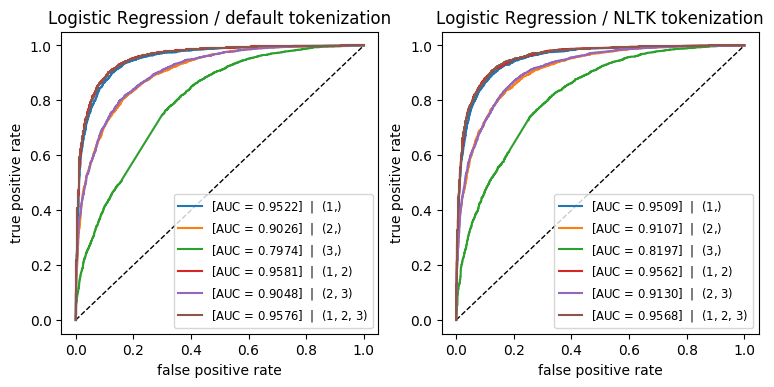

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

fmt = '[AUC = {:.4f}]  $|$  {}'

for (i, y) in default_models_lr_y.items():
    fp, tp, thresh = metrics.roc_curve(1.0 * Yval, y)
    label = fmt.format(metrics.auc(fp, tp), tuple(np.atleast_1d(i)))
    ax1.plot(fp, tp, label=label)

for (i, y) in nltk_models_lr_y.items():
    fp, tp, thresh = metrics.roc_curve(1.0 * Yval, y)
    label = fmt.format(metrics.auc(fp, tp), tuple(np.atleast_1d(i)))
    ax2.plot(fp, tp, label=label)
    
label_roc_ax(ax1, 'Logistic Regression / default tokenization')
label_roc_ax(ax2, 'Logistic Regression / NLTK tokenization')

### Neural Network (dense)

In [45]:
def get_new_nn(Xshape):
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(Xshape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, 'softmax'))
    optimizer = tf.keras.optimizers.Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

In [46]:
default_models_nn = {}
default_models_nn_y = {}
for i in all_combos_ngrams:
    print(f'Fitting NNs for [{i}]')
    # fit to train subset
    X = get_X(default_train_vectors, i, itrain)
    model = get_new_nn(X.shape)
    ytrain = np.zeros((X.shape[0], 2))
    r = np.arange(X.shape[0])
    ytrain[r,Ytrain] = 1
    kw = dict(epochs=2, batch_size=64)
    model.fit(X, ytrain, **kw)
    # test on validation subset
    Xval = get_X(default_train_vectors, i, ival)
    y = model.predict_proba(Xval)[:,1]
    default_models_nn[i] = model
    default_models_nn_y[i] = y

Fitting NNs for [1]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
18750/18750 [==============================] - 6s 326us/sample - loss: 0.6286
Epoch 2/2
18750/18750 [==============================] - 3s 144us/sample - loss: 0.3187
Fitting NNs for [2]
Epoch 1/2
18750/18750 [==============================] - 3s 175us/sample - loss: 0.6850
Epoch 2/2
18750/18750 [==============================] - 3s 144us/sample - loss: 0.5137
Fitting NNs for [3]
Epoch 1/2
18750/18750 [==============================] - 3s 176us/sample - loss: 0.6912
Epoch 2/2
18750/18750 [==============================] - 3s 148us/sample - loss: 0.6666
Fitting NNs for [(1, 2)]
Epoch 1/2
18750/18750 [==============================] - 5s 249us/sample - loss: 0.5992
Epoch 2/2
18750/18750 [==============================] - 4s 201u

In [47]:
nltk_models_nn = {}
nltk_models_nn_y = {}
for i in all_combos_ngrams:
    print(f'Fitting NNs for [{i}]')
    # fit to train subset
    X = get_X(nltk_train_vectors, i, itrain)
    model = get_new_nn(X.shape)
    ytrain = np.zeros((X.shape[0], 2))
    r = np.arange(X.shape[0])
    ytrain[r,Ytrain] = 1
    kw = dict(epochs=2, batch_size=64)
    model.fit(X, ytrain, **kw)
    # test on validation subset
    Xval = get_X(nltk_train_vectors, i, ival)
    y = model.predict_proba(Xval)[:,1]
    nltk_models_nn[i] = model
    nltk_models_nn_y[i] = y

Fitting NNs for [1]
Epoch 1/2
18750/18750 [==============================] - 4s 202us/sample - loss: 0.6289
Epoch 2/2
18750/18750 [==============================] - 3s 150us/sample - loss: 0.3192
Fitting NNs for [2]
Epoch 1/2
18750/18750 [==============================] - 4s 204us/sample - loss: 0.6783
Epoch 2/2
18750/18750 [==============================] - 3s 153us/sample - loss: 0.4553
Fitting NNs for [3]
Epoch 1/2
18750/18750 [==============================] - 4s 206us/sample - loss: 0.6915
Epoch 2/2
18750/18750 [==============================] - 3s 152us/sample - loss: 0.6632
Fitting NNs for [(1, 2)]
Epoch 1/2
18750/18750 [==============================] - 5s 275us/sample - loss: 0.5881
Epoch 2/2
18750/18750 [==============================] - 4s 204us/sample - loss: 0.2651
Fitting NNs for [(2, 3)]
Epoch 1/2
18750/18750 [==============================] - 5s 278us/sample - loss: 0.6815
Epoch 2/2
18750/18750 [==============================] - 4s 204us/sample - loss: 0.4539
Fitting NN

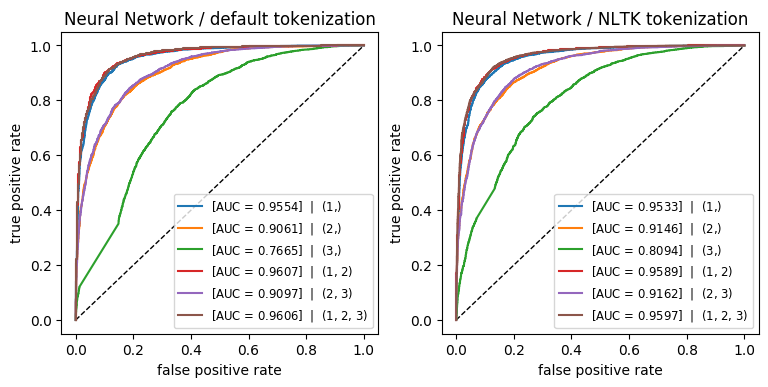

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

fmt = '[AUC = {:.4f}]  $|$  {}'

for (i, y) in default_models_nn_y.items():
    fp, tp, thresh = metrics.roc_curve(1.0 * Yval, y)
    label = fmt.format(metrics.auc(fp, tp), tuple(np.atleast_1d(i)))
    ax1.plot(fp, tp, label=label)

for (i, y) in nltk_models_nn_y.items():
    fp, tp, thresh = metrics.roc_curve(1.0 * Yval, y)
    label = fmt.format(metrics.auc(fp, tp), tuple(np.atleast_1d(i)))
    ax2.plot(fp, tp, label=label)
    
label_roc_ax(ax1, 'Neural Network / default tokenization')
label_roc_ax(ax2, 'Neural Network / NLTK tokenization')

### Random Forest

In [49]:
default_models_rf = {}
default_models_rf_y = {}
for i in all_combos_ngrams:
    print(f'Fitting for [{i}]')
    # fit to train subset
    X = get_X(default_train_vectors, i, itrain)
    kw = dict(n_estimators=200, max_depth=20, n_jobs=10)
    model = ensemble.RandomForestClassifier(**kw)
    model.fit(X, Ytrain)
    # test on validation subset
    Xval = get_X(default_train_vectors, i, ival)
    y = model.predict_proba(Xval)[:,1]
    default_models_rf[i] = model
    default_models_rf_y[i] = y

Fitting for [1]
Fitting for [2]
Fitting for [3]
Fitting for [(1, 2)]
Fitting for [(2, 3)]
Fitting for [(1, 2, 3)]


In [50]:
nltk_models_rf = {}
nltk_models_rf_y = {}
for i in all_combos_ngrams:
    print(f'Fitting for [{i}]')
    # fit to train subset
    X = get_X(nltk_train_vectors, i, itrain)
    kw = dict(n_estimators=200, max_depth=20, n_jobs=10)
    model = ensemble.RandomForestClassifier(**kw)
    model.fit(X, Ytrain)
    # test on validation subset
    Xval = get_X(nltk_train_vectors, i, ival)
    y = model.predict_proba(Xval)[:,1]
    nltk_models_rf[i] = model
    nltk_models_rf_y[i] = y

Fitting for [1]
Fitting for [2]
Fitting for [3]
Fitting for [(1, 2)]
Fitting for [(2, 3)]
Fitting for [(1, 2, 3)]


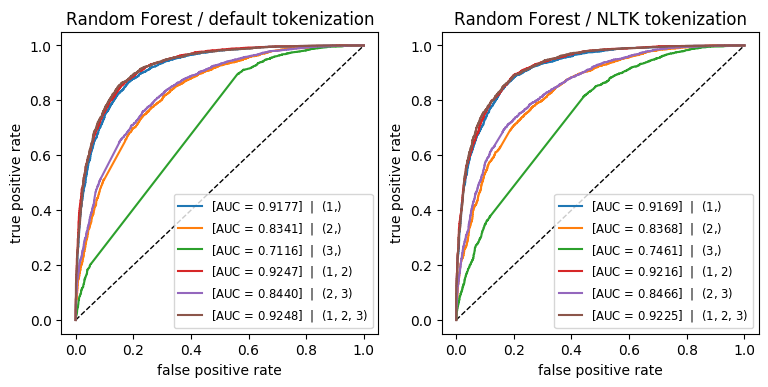

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

fmt = '[AUC = {:.4f}]  $|$  {}'

for (i, y) in default_models_rf_y.items():
    fp, tp, thresh = metrics.roc_curve(1.0 * Yval, y)
    label = fmt.format(metrics.auc(fp, tp), tuple(np.atleast_1d(i)))
    ax1.plot(fp, tp, label=label)

for (i, y) in nltk_models_rf_y.items():
    fp, tp, thresh = metrics.roc_curve(1.0 * Yval, y)
    label = fmt.format(metrics.auc(fp, tp), tuple(np.atleast_1d(i)))
    ax2.plot(fp, tp, label=label)
    
label_roc_ax(ax1, 'Random Forest / default tokenization')
label_roc_ax(ax2, 'Random Forest / NLTK tokenization')

### XGBoost

This one is a bit more expensive to train, so we'll skip the obviously less-useful (2,), (3,), and (2,3) variants.

In [52]:
xgb_combos_ngrams = [1, (1,2), (1,2,3)]

In [53]:
default_models_xgb = {}
default_models_xgb_y = {}
for i in xgb_combos_ngrams:
    print(f'Fitting for [{i}]')
    # fit to train subset
    X = get_X(default_train_vectors, i, itrain)
    kw = dict(n_estimators=200, max_depth=20, n_jobs=10, objective='binary:logistic')
    model = xgb.XGBClassifier(**kw)
    model.fit(X, Ytrain)
    # test on validation subset
    Xval = get_X(default_train_vectors, i, ival)
    y = model.predict_proba(Xval)[:,1]
    default_models_xgb[i] = model
    default_models_xgb_y[i] = y

Fitting for [1]
Fitting for [(1, 2)]
Fitting for [(1, 2, 3)]


In [54]:
nltk_models_xgb = {}
nltk_models_xgb_y = {}
for i in xgb_combos_ngrams:
    print(f'Fitting for [{i}]')
    # fit to train subset
    X = get_X(nltk_train_vectors, i, itrain)
    kw = dict(n_estimators=200, max_depth=20, n_jobs=10, objective='binary:logistic')
    model = xgb.XGBClassifier(**kw)
    model.fit(X, Ytrain)
    # test on validation subset
    Xval = get_X(nltk_train_vectors, i, ival)
    y = model.predict_proba(Xval)[:,1]
    nltk_models_xgb[i] = model
    nltk_models_xgb_y[i] = y

Fitting for [1]
Fitting for [(1, 2)]
Fitting for [(1, 2, 3)]


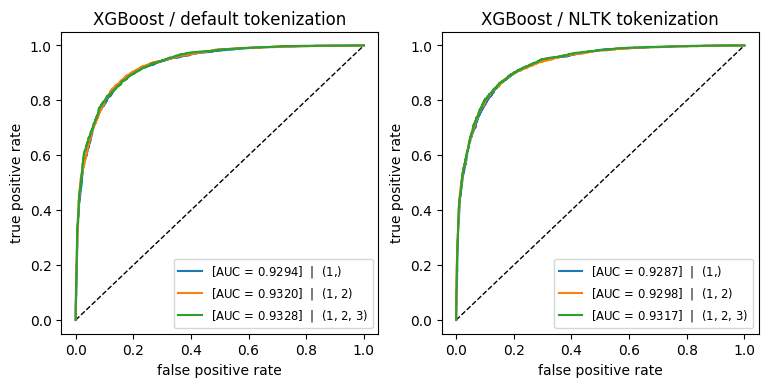

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

fmt = '[AUC = {:.4f}]  $|$  {}'

for (i, y) in default_models_xgb_y.items():
    fp, tp, thresh = metrics.roc_curve(1.0 * Yval, y)
    label = fmt.format(metrics.auc(fp, tp), tuple(np.atleast_1d(i)))
    ax1.plot(fp, tp, label=label)

for (i, y) in nltk_models_xgb_y.items():
    fp, tp, thresh = metrics.roc_curve(1.0 * Yval, y)
    label = fmt.format(metrics.auc(fp, tp), tuple(np.atleast_1d(i)))
    ax2.plot(fp, tp, label=label)
    
label_roc_ax(ax1, 'XGBoost / default tokenization')
label_roc_ax(ax2, 'XGBoost / NLTK tokenization')

## Choosing a final architecture

My main observations in the above are:

* Logistic regression and neural network yield comparable performance; tree-based methods perform somewhat more poorly _given the arbitrary hyperparameters used_.  For some applications, brute force optimization of those hyperparameters might be worth the effort.
* NLTK's tokenization gives no advantage over sklearn's default word-based tokenization as applied here.  This may be because NLTK's method is designed to capture more details within sentences, including punctuation that we discarded.  More advanced tokenization _including_ punctuation might be more useful with a corresponding more complex learner such as LSTM.
* For the neural network and tree-based classifiers, including trigrams appears to be helpful.  For logistic regression, which cannot exploit _relationships between_ unigrams/bigrams/trigrams, we appear to get best performance with just unigrams+bigrams. (Randomized NN initialization means fluctuations are visible in repeated testing; cross validation would give more rigorous support to this argument at the expense of compute time.)

Often an ensemble method yields better results, so now we check whether we can improve performance by averaging over models — in each case, taking the best classifier obtained so far using each method independently.

In [56]:
best_lr_y = default_models_lr_y[1,2]
best_nn_y = default_models_nn_y[1,2,3]
best_rf_y = default_models_rf_y[1,2,3]
best_xgb_y = default_models_xgb_y[1,2,3]

best_y = dict(LR=best_lr_y, NN=best_nn_y, RF=best_rf_y, XGB=best_xgb_y)

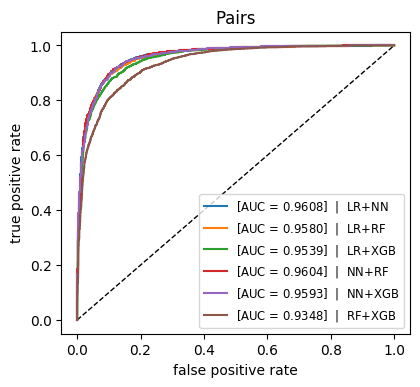

In [57]:
fig, ax = plt.subplots(figsize=(4.5, 4))

for ( (l1, y1), (l2, y2) ) in itertools.combinations(best_y.items(), 2):
    fp, tp, thresh = metrics.roc_curve(1.0 * Yval, np.mean([y1, y2], axis=0))
    label = fmt.format(metrics.auc(fp, tp), f'{l1}+{l2}')
    ax.plot(fp, tp, label=label)

label_roc_ax(ax, 'Pairs')

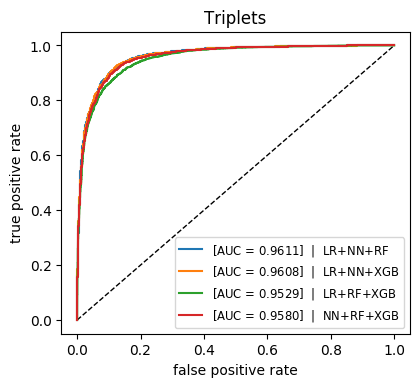

In [58]:
fig, ax = plt.subplots(figsize=(4.5, 4))

for ( (l1, y1), (l2, y2), (l3, y3) ) in itertools.combinations(best_y.items(), 3):
    fp, tp, thresh = metrics.roc_curve(1.0 * Yval, np.mean([y1, y2, y3], axis=0))
    label = fmt.format(metrics.auc(fp, tp), f'{l1}+{l2}+{l3}')
    ax.plot(fp, tp, label=label)

label_roc_ax(ax, 'Triplets')

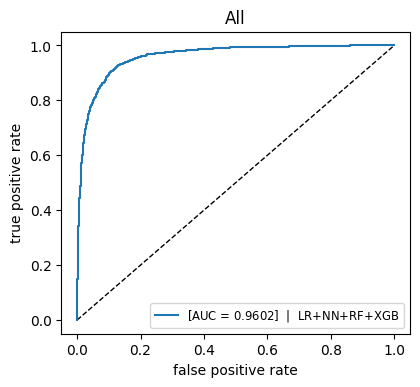

In [59]:
fig, ax = plt.subplots(figsize=(4.5, 4))

y = np.mean(list(best_y.values()), axis=0)
fp, tp, thresh = metrics.roc_curve(1.0 * Yval, y)
label = fmt.format(metrics.auc(fp, tp), f'LR+NN+RF+XGB')
ax.plot(fp, tp, label=label)

label_roc_ax(ax, 'All')

## Final model

The best combinations above seem to be (LR+NN), (NN+RF) and (LR+NN+RF).  For our final model, we'll go with (LR+NN), which combines the simplicity and legibility of LR with the sensitivity to unexpected relationships of NNs.  We'll sacrifice a small potential gain, and avoid a small increase in complexity, from the addition of RF.  For an important production model, we would of course take more care in quantifying aspects of this decision such as engineering costs and compute resource requirements, in addition to computing more robust performance metrics via cross validation and running brute-force hyperparameter optimization scans.

So our final model will consist of the (equal-weight) average of:

* Logistic Regression with unigrams and bigrams
* Neural Network with unigrams, bigrams, and trigrams

In [60]:
Xtrain12 = get_X(default_train_vectors, (1,2))
Xtrain123 = get_X(default_train_vectors, (1,2,3))

In [61]:
Ytrain = train.pos.values

In [62]:
ytrain = np.zeros((Xtrain12.shape[0], 2))
r = np.arange(Xtrain12.shape[0])
ytrain[r,Ytrain] = 1

In [63]:
final_model_lr = linear_model.LogisticRegression(solver='lbfgs')
%time final_model_lr.fit(Xtrain12, Ytrain)

CPU times: user 524 ms, sys: 4 ms, total: 528 ms
Wall time: 525 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
final_model_nn = get_new_nn(Xtrain123.shape)
kw = dict(epochs=2, batch_size=64)
%time final_model_nn.fit(Xtrain123, ytrain, **kw)

Epoch 1/2
25000/25000 [==============================] - 9s 362us/sample - loss: 0.5274
Epoch 2/2
25000/25000 [==============================] - 7s 294us/sample - loss: 0.2252
CPU times: user 17.5 s, sys: 3.12 s, total: 20.7 s
Wall time: 16.8 s


Finally, we load the test dataset:

In [65]:
%time test = load_sup_dataset(TEST_PATH)

Reading neg ...
12000 ...
Reading pos ...
12000 ...
CPU times: user 15.1 s, sys: 2.17 s, total: 17.3 s
Wall time: 25 s


In [66]:
%time unigrams_test = default_vectorizers[1].transform(test.text.values)
%time bigrams_test  = default_vectorizers[2].transform(test.text.values)
%time trigrams_test = default_vectorizers[3].transform(test.text.values)

CPU times: user 3.64 s, sys: 39.6 ms, total: 3.68 s
Wall time: 3.67 s
CPU times: user 4.63 s, sys: 8.07 ms, total: 4.63 s
Wall time: 4.62 s
CPU times: user 4.67 s, sys: 27.7 ms, total: 4.69 s
Wall time: 4.68 s


We make our predictions:

In [67]:
Xtest12 = sparse.csr_matrix(np.hstack((
    unigrams_test.toarray(),
    bigrams_test.toarray(),
)))

In [68]:
Xtest123 = sparse.csr_matrix(np.hstack((
    unigrams_test.toarray(),
    bigrams_test.toarray(),
    trigrams_test.toarray(),
)))

In [69]:
Ytest = test.pos.values

In [70]:
%time ylr = final_model_lr.predict_proba(Xtest12)[:,1]

CPU times: user 7.65 ms, sys: 0 ns, total: 7.65 ms
Wall time: 6.73 ms


In [71]:
%time ynn = final_model_nn.predict(Xtest123)[:,1]

CPU times: user 3.21 s, sys: 239 ms, total: 3.45 s
Wall time: 2.59 s


And then we inspect the ROC curves:

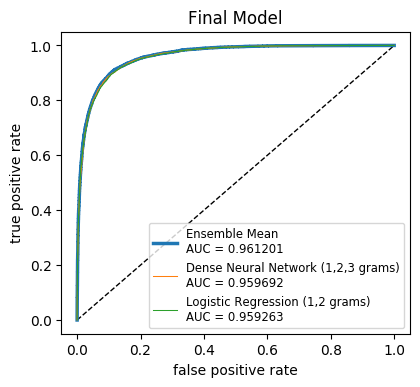

In [72]:
fig, ax = plt.subplots(figsize=(4.5,4))

ymean = np.mean([ynn, ylr], axis=0)
fp, tp, thresh = metrics.roc_curve(1.0 * Ytest, ymean)
ax.plot(fp, tp,
        label='{}\nAUC = {:.6f}'.format(
            'Ensemble Mean', metrics.auc(fp, tp)), lw=2.5)

fp, tp, thresh = metrics.roc_curve(1.0 * Ytest, ynn)
ax.plot(fp, tp,
        label='{}\nAUC = {:.6f}'.format(
            'Dense Neural Network (1,2,3 grams)', metrics.auc(fp, tp)), lw=.75)

fp, tp, thresh = metrics.roc_curve(1.0 * Ytest, ylr)
ax.plot(fp, tp,
        label='{}\nAUC = {:.6f}'.format(
            'Logistic Regression (1,2 grams)', metrics.auc(fp, tp)), lw=.75)

label_roc_ax(ax, 'Final Model')

In [73]:
print('=== Accuracy summary ===')
acc_fmt = '{:>13s}: {:.4f}'
print(acc_fmt.format('mean(LR,NN)', metrics.accuracy_score(Ytest, (ymean > .5))))
print(acc_fmt.format('NN', metrics.accuracy_score(Ytest, (ynn > .5))))
print(acc_fmt.format('LR', metrics.accuracy_score(Ytest, (ylr > .5))))

=== Accuracy summary ===
  mean(LR,NN): 0.8948
           NN: 0.8928
           LR: 0.8929


The final model obtains AUC = 0.9612 with an accuracy of 89.48% (arbitrarily truncating at 4 digits) for a decision boundary at y = 0.5.

We can do some inspection to see how the LR+NN model outperforms either independently.  Here we see that there are regions in which one or the other has misclassified some reviews, but the LR+NN averaged model still puts the review on the correct side of the overall decision boundary:

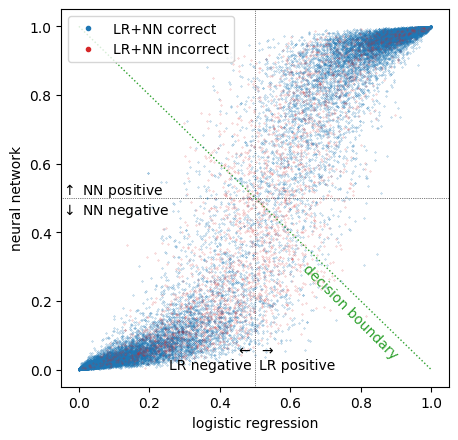

In [74]:
fig, ax = plt.subplots(figsize=(5,5))
ymean = .5 * (ylr + ynn)
mask = (1 * (ymean > .5)) == Ytest
ax.plot(ylr[mask], ynn[mask], '.', ms=.5, alpha=.75, )
ax.plot(ylr[~mask], ynn[~mask], '.', ms=.5, alpha=.5, color='C3')
nans = [np.nan]
ax.plot(nans, nans, '.', color='C0', label='LR+NN correct')
ax.plot(nans, nans, '.', color='C3', label='LR+NN incorrect')
ax.set_xlabel('logistic regression')
ax.set_ylabel('neural network')
ax.axvline(.5, color='k', ls=':', lw=.5, zorder=-10)
ax.axhline(.5, color='k', ls=':', lw=.5, zorder=-10)
ax.plot([0, 1], [1, 0], color='C2', ls=':', lw=1, zorder=-10)
ax.text(.77, .17, 'decision boundary', color='C2', rotation=-45, ha='center', va='center');
ax.text(-.05, .51, r'$\uparrow$ NN positive')
ax.text(-.05, .49, r'$\downarrow$ NN negative', va='top')
ax.text(.51, 0, r'$\rightarrow$' + '\nLR positive');
ax.text(.49, 0, r'$\leftarrow$' + '\nLR negative', ha='right')
ax.legend(loc='upper left');

With that said, LR and NN still agree more closely with each other than their average prediction agrees with the truth:

In [75]:
print('LR vs NN:')
print(metrics.confusion_matrix(ylr > .5, ynn > .5))
print('\n (LR+NN) vs truth:')
print(metrics.confusion_matrix(ymean > .5, Ytest))

LR vs NN:
[[12067   307]
 [  881 11745]]

 (LR+NN) vs truth:
[[11331  1462]
 [ 1169 11038]]


## Follow-up on misclassifications

Let's examine some examples of reviews in which the prediction was confident ($p\geq0.9$ for both LR and NN) and yet wrong:

In [76]:
mask_wayoff = np.where((ylr > .9) & (ynn > .9) & ((ymean > .5) != Ytest))[0]
print('=== Prediction: Positive Review ===')
for i in mask_wayoff[:3]:
    print(90 * '-')
    print('Rating: {}'.format(test.rating.values[i]))
    print('Ylr / Ynn / Ymean: {:.3f} / {:.3f} / {:.3f}'.format(ylr[i], ynn[i], ymean[i]))
    print('Ytrue: {}'.format(Ytest[i]))
    pfill(test.text.values[i])

=== Prediction: Positive Review ===
------------------------------------------------------------------------------------------
Rating: 1
Ylr / Ynn / Ymean: 0.909 / 0.979 / 0.944
Ytrue: 0
This movie changed my life! Hogan's performance was nothing short of incredible, and I
still haven't recovered from his exclusion from the 1990 Oscar nominations. And as
brightly as the Hulkster shines in this movie, you can't discount the brilliant writing
and direction that vaults this masterpiece in to the highest strata of achievement in
film. If you haven't seen this movie, drop what your doing right now and get yourself a
copy. I guarantee it will blow your mind. And if you don't like it, then I just have one
question for you.... Watcha gonna do when the 24 inch pythons and Hulkamania runs wild on
you!!!!
------------------------------------------------------------------------------------------
Rating: 1
Ylr / Ynn / Ymean: 0.909 / 0.965 / 0.937
Ytrue: 0
I am currently 22 years old, and remember s

Here we see some interesting results.  The first listing seems unambiguously positive to me; what happened?  Judging by the subject of the movie (something about Hulk Hogan, produced by the WWF under Vince McMahon) I guess it's just sarcasm that can't be detected without additional context.  (https://www.imdb.com/review/rw0273629/)

The second is clearly negative, but words like _mystical, fantastic, creativity, enjoy_ probably confuse the models.

The third notes redeeming qualities, and is maybe just coming from an especially harsh (numerically) critic.

In [77]:
mask_wayoff = np.where((ylr < .1) & (ynn < .1) & ((ymean > .5) != Ytest))[0]
print('=== Prediction: Negative Review ===')
for i in mask_wayoff[:3]:
    print(90 * '-')
    print('Rating: {}'.format(test.rating.values[i]))
    print('Ylr / Ynn / Ymean: {:.3f} / {:.3f} / {:.3f}'.format(ylr[i], ynn[i], ymean[i]))
    print('Ytrue: {}'.format(Ytest[i]))
    pfill(test.text.values[i])

=== Prediction: Negative Review ===
------------------------------------------------------------------------------------------
Rating: 8
Ylr / Ynn / Ymean: 0.097 / 0.030 / 0.064
Ytrue: 1
Count me as being one who is happy to see no Hastings in this episode. The poor-man's Dr.
Watson does nothing for me, as he simply drags down every scene he's in. Japp is often
necessary to the story as the representative of officialdom, and a little Miss Lemon is
fine for seasoning, but Hastings swings from painfully dim to over-mannered in different
episodes. If I have to sit through one more vacuous "Oh, I say there!" I'll take the gas-
pipe.As a general rule, the more Poirot you get in a Poirot story, the better. Every line
for Hastings is one taken away from Poirot. And I've never read the books, so I really
don't care about fidelity to Christie's characters. A lot of viewers/reviewers seem to
have a problem with separating the movies from the books. If you want the book as written,
then read it. 

These are even more interesting!  In the first, the writer uses a highly negative tone, yet they are seemingly happy with this specific work which seems to be part of a series.  Digging a little deeper, it turns out that this isn't even a "movie" in the commonly understood sense.  It's an episode of a 13-season TV show!  (https://www.imdb.com/title/tt0479977/)

The second review seems unambiguously negative.  The writer complains about acting and vocal quality; says the humor doesn't work and the script makes it boring; and the suggests storytelling is unfocused.  The review closes with "7/10" — the threshold for inclusion in "positive" sample — yet in the dataset it is marked as rated 10/10.  I guess it was user error; the 10/10 numerical rating survives online to this day.  (https://www.imdb.com/review/rw1657285/)

The last one comes across as reservedly positive; the writer is just committed to managing expectations.

## Conclusions

In this notebook, we've performed sentiment analysis on "movie" reviews using two tokenization methods and several classification models.  Our final model achieves accuracy ~ 89.4%, with ROC AUC ~ 0.96.

Our treatment of the vocabulary is somewhat simpler to implement than that applied in the original paper [1], yet we obtain slightly better accuracy than their best-reported value of 88.89%.  It isn't immediately obvious why this should be the case.  However, my guess is that the slight advantage here — if it is real — stems from the potential for the neural network to exploit patterns in related frequency distributions of bigrams and trigrams in addition to the commonly-used unigrams.

The implementation used here is not immediately parallelizable, but with some effort it could be made so.  Custom code for TF-IDF could be used to parallelize the overall vocabulary weighting, and thus the final choice of n-grams to include.  Logistic regression and neural network models could be generalized to ensembles of such models, each fitted in parallel to different subsets of an arbitrarily large dataset.  Such a generalization would have the added benefit of avoiding overfitting.

With just a brief inspection of misclassified events, we gained insight into some important data quality concerns.  These include at least the following:

1. **User Error:** Sometimes the user doesn't write down what was intended (e.g. 7/10 in the text, 10/10 numerical rating entered).
2. **Dataset Scope:** What is a movie, _really_?  Do TV show episodes count if they're 90 minutes?
3. **Meaning of Rating:** The 1-10 rating scale doesn't have a universal meaning.  To many Americans, below 6/10 is already an F, a 60/100, a failing grade.  Others apply a more linear interpretation, where 3/10 is very bad and 1/10 is fair for the worst movies of all time.  For a mission-critical model, the operational definition of "positive" or "negative" review would need to be considered more carefully.  We will consider one alternative definition (rating is high relative to per-user mean) in the recommender system section of this project.
4. **Sarcasm:** While this isn't strictly a problem with the data, it can be extremely difficult to detect — even for a human, let alone a numerical algorithm!  I plan to read more about the state of the art in sarcasm detection; for this work, there isn't much we can do about it.

According to the Kaggle leaderboard for this exercise, this solution would be in the 89th percentile [2].  Unfortunately, the submitted solutions are not public.  I suspect that some have had success using embedded layers and LSTMs in their models, among other possibilities.  However, in light of the issues outlined above, as well as the fact that the test set has been public for years, it is possible that some of the top submissions (#1 claims AUC > 0.99!) may have gamed the metric to some extent.


[1] https://www.aclweb.org/anthology/P11-1015 <br/>
[2] https://www.kaggle.com/c/word2vec-nlp-tutorial/leaderboard
